In [ ]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Setting display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# File paths to datasets located in '/content/' directory
file_paths = {
    "cost_of_living": "/content/Cost_of_Living_Index_by_Country_2024.csv",
    "mental_health": "/content/Mental health Depression disorder Data.csv",
    "obesity": "/content/obesity_data.csv",
    "substance_use": "/content/share-with-alcohol-and-substance-use-disorders 1990-2016.csv",
    "suicide_rate": "/content/suicide-rate-by-country-2023.csv",
    "world_happiness": "/content/World Happiness Report 2005-2021.csv",
    "youth_smoking_drug": "/content/youth_smoking_drug_data_10000_rows_expanded.csv"
}

# Function to load data
def load_data(file_path, dataset_name):
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df.name = dataset_name  # Assign dataset name to DataFrame
            return df
        else:
            print(f"Unsupported file type for dataset '{dataset_name}'.")
            return None
    except Exception as e:
        print(f"Error loading dataset '{dataset_name}': {e}")
        return None

# Load datasets into a dictionary
dataframes = {}
for dataset_name, file_path in file_paths.items():
    df = load_data(file_path, dataset_name)
    if df is not None:
        dataframes[dataset_name] = df

# Function to validate data
def validate_data(df, dataset_name):
    print(f"\nValidating dataset '{dataset_name}'...")
    print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")
    print("Data types:")
    print(df.dtypes)
    print("Missing values:")
    print(df.isnull().sum())
    print(f"Validation of dataset '{dataset_name}' completed.")

# Standardizing Column Names for All Datasets
def standardize_columns(df):
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
    return df

for name, df in dataframes.items():
    dataframes[name] = standardize_columns(df)

# Renaming Columns to Match Expected Names
def rename_columns(df, columns_dict):
    df.rename(columns=columns_dict, inplace=True)
    return df

# Correcting 'suicide_rate' dataset column names
if 'suicide_rate' in dataframes:
    suicide_rate = dataframes['suicide_rate']
    suicide_rate = rename_columns(suicide_rate, {'rate2019both': 'suicide_rate', 'country': 'country_name'})
    dataframes['suicide_rate'] = suicide_rate

# Correcting 'cost_of_living' dataset column names
if 'cost_of_living' in dataframes:
    cost_of_living = dataframes['cost_of_living']
    cost_of_living = rename_columns(cost_of_living, {'country': 'country_name'})
    dataframes['cost_of_living'] = cost_of_living

# Proceed with Data Cleaning
def clean_data(df, missing_value_method):
    # Convert object columns to numeric where possible
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='ignore')
    # Handle missing values
    if missing_value_method == "drop":
        df.dropna(inplace=True)
    elif missing_value_method == "mean":
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

for name, df in dataframes.items():
    print(f"\nCleaning dataset '{name}'...")
    method = "drop" if name in ["cost_of_living", "world_happiness"] else "mean"
    dataframes[name] = clean_data(df, missing_value_method=method)
    print(f"Dataset '{name}' cleaned.")

# Re-validate Data After Cleaning
for name, df in dataframes.items():
    validate_data(df, name)

# Update Merging Strategy to Include Correct Columns and Keys
def merge_datasets(merged_df, df_to_merge, on_columns, df_name):
    if all(col in merged_df.columns for col in on_columns) and all(col in df_to_merge.columns for col in on_columns):
        merged_df = pd.merge(merged_df, df_to_merge, on=on_columns, how='left')
    else:
        print(f"Warning: Columns for merging with '{df_name}' not found.")
    return merged_df

try:
    # Initialize the merged DataFrame with the 'world_happiness' dataset
    merged_df = dataframes["world_happiness"].copy()
    print("\nInitialized merged DataFrame with 'world_happiness' dataset.")

    # Merge datasets
    merged_df = merge_datasets(merged_df, dataframes['mental_health'], ['country_name', 'year'], 'mental_health')
    merged_df = merge_datasets(
        merged_df,
        dataframes['substance_use'].rename(columns={'entity': 'country_name'}),
        ['country_name', 'year'],
        'substance_use'
    )
    merged_df = merge_datasets(merged_df, dataframes['suicide_rate'], ['country_name'], 'suicide_rate')
    merged_df = merge_datasets(merged_df, dataframes['cost_of_living'], ['country_name'], 'cost_of_living')
    # Exclude 'obesity' dataset due to missing country data

    # Display the first few rows
    print("\nPreview of the merged dataset:")
    print(merged_df.head())

except Exception as ex:
    print(f"An unexpected error occurred during merging: {ex}")

# Re-validate Merged Data
validate_data(merged_df, 'merged_dataset')

# Check if the required columns are now present
required_columns = ['suicide_rate', 'cost_of_living_index']
missing_columns = [col for col in required_columns if col not in merged_df.columns]
if missing_columns:
    print(f"\nAfter merging, the following required columns are still missing: {missing_columns}")
else:
    print("\nAll required columns are present in the merged dataset.")

<ipython-input-76-e88d6e909ff1>:32: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-76-e88d6e909ff1>:89: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')



Cleaning dataset 'cost_of_living'...
Dataset 'cost_of_living' cleaned.

Cleaning dataset 'mental_health'...
Dataset 'mental_health' cleaned.

Cleaning dataset 'obesity'...
Dataset 'obesity' cleaned.

Cleaning dataset 'substance_use'...
Dataset 'substance_use' cleaned.

Cleaning dataset 'suicide_rate'...
Dataset 'suicide_rate' cleaned.

Cleaning dataset 'world_happiness'...
Dataset 'world_happiness' cleaned.

Cleaning dataset 'youth_smoking_drug'...
Dataset 'youth_smoking_drug' cleaned.

Validating dataset 'cost_of_living'...
Number of rows: 121, Number of columns: 8
Data types:
rank                                int64
country_name                       object
cost_of_living_index              float64
rent_index                        float64
cost_of_living_plus_rent_index    float64
groceries_index                   float64
restaurant_price_index            float64
local_purchasing_power_index      float64
dtype: object
Missing values:
rank                              0
country_name


Performing correlation analysis on selected numerical columns.

Correlation Matrix:
                                                        year  life_ladder  log_gdp_per_capita  social_support  healthy_life_expectancy_at_birth  freedom_to_make_life_choices  generosity  perceptions_of_corruption  positive_affect  negative_affect  confidence_in_national_government  prevalence_-_alcohol_and_substance_use_disorders:_both_(age-standardized_percent)_(%)  suicide_rate  rate2019male  rate2019female      rank  cost_of_living_index  rent_index  cost_of_living_plus_rent_index  groceries_index  restaurant_price_index  local_purchasing_power_index
year                                                1.000000     0.034308            0.107810       -0.015659                          0.160436                      0.146335    0.028812                  -0.063645         0.028769         0.122100                          -0.052824                                          -0.022042                       

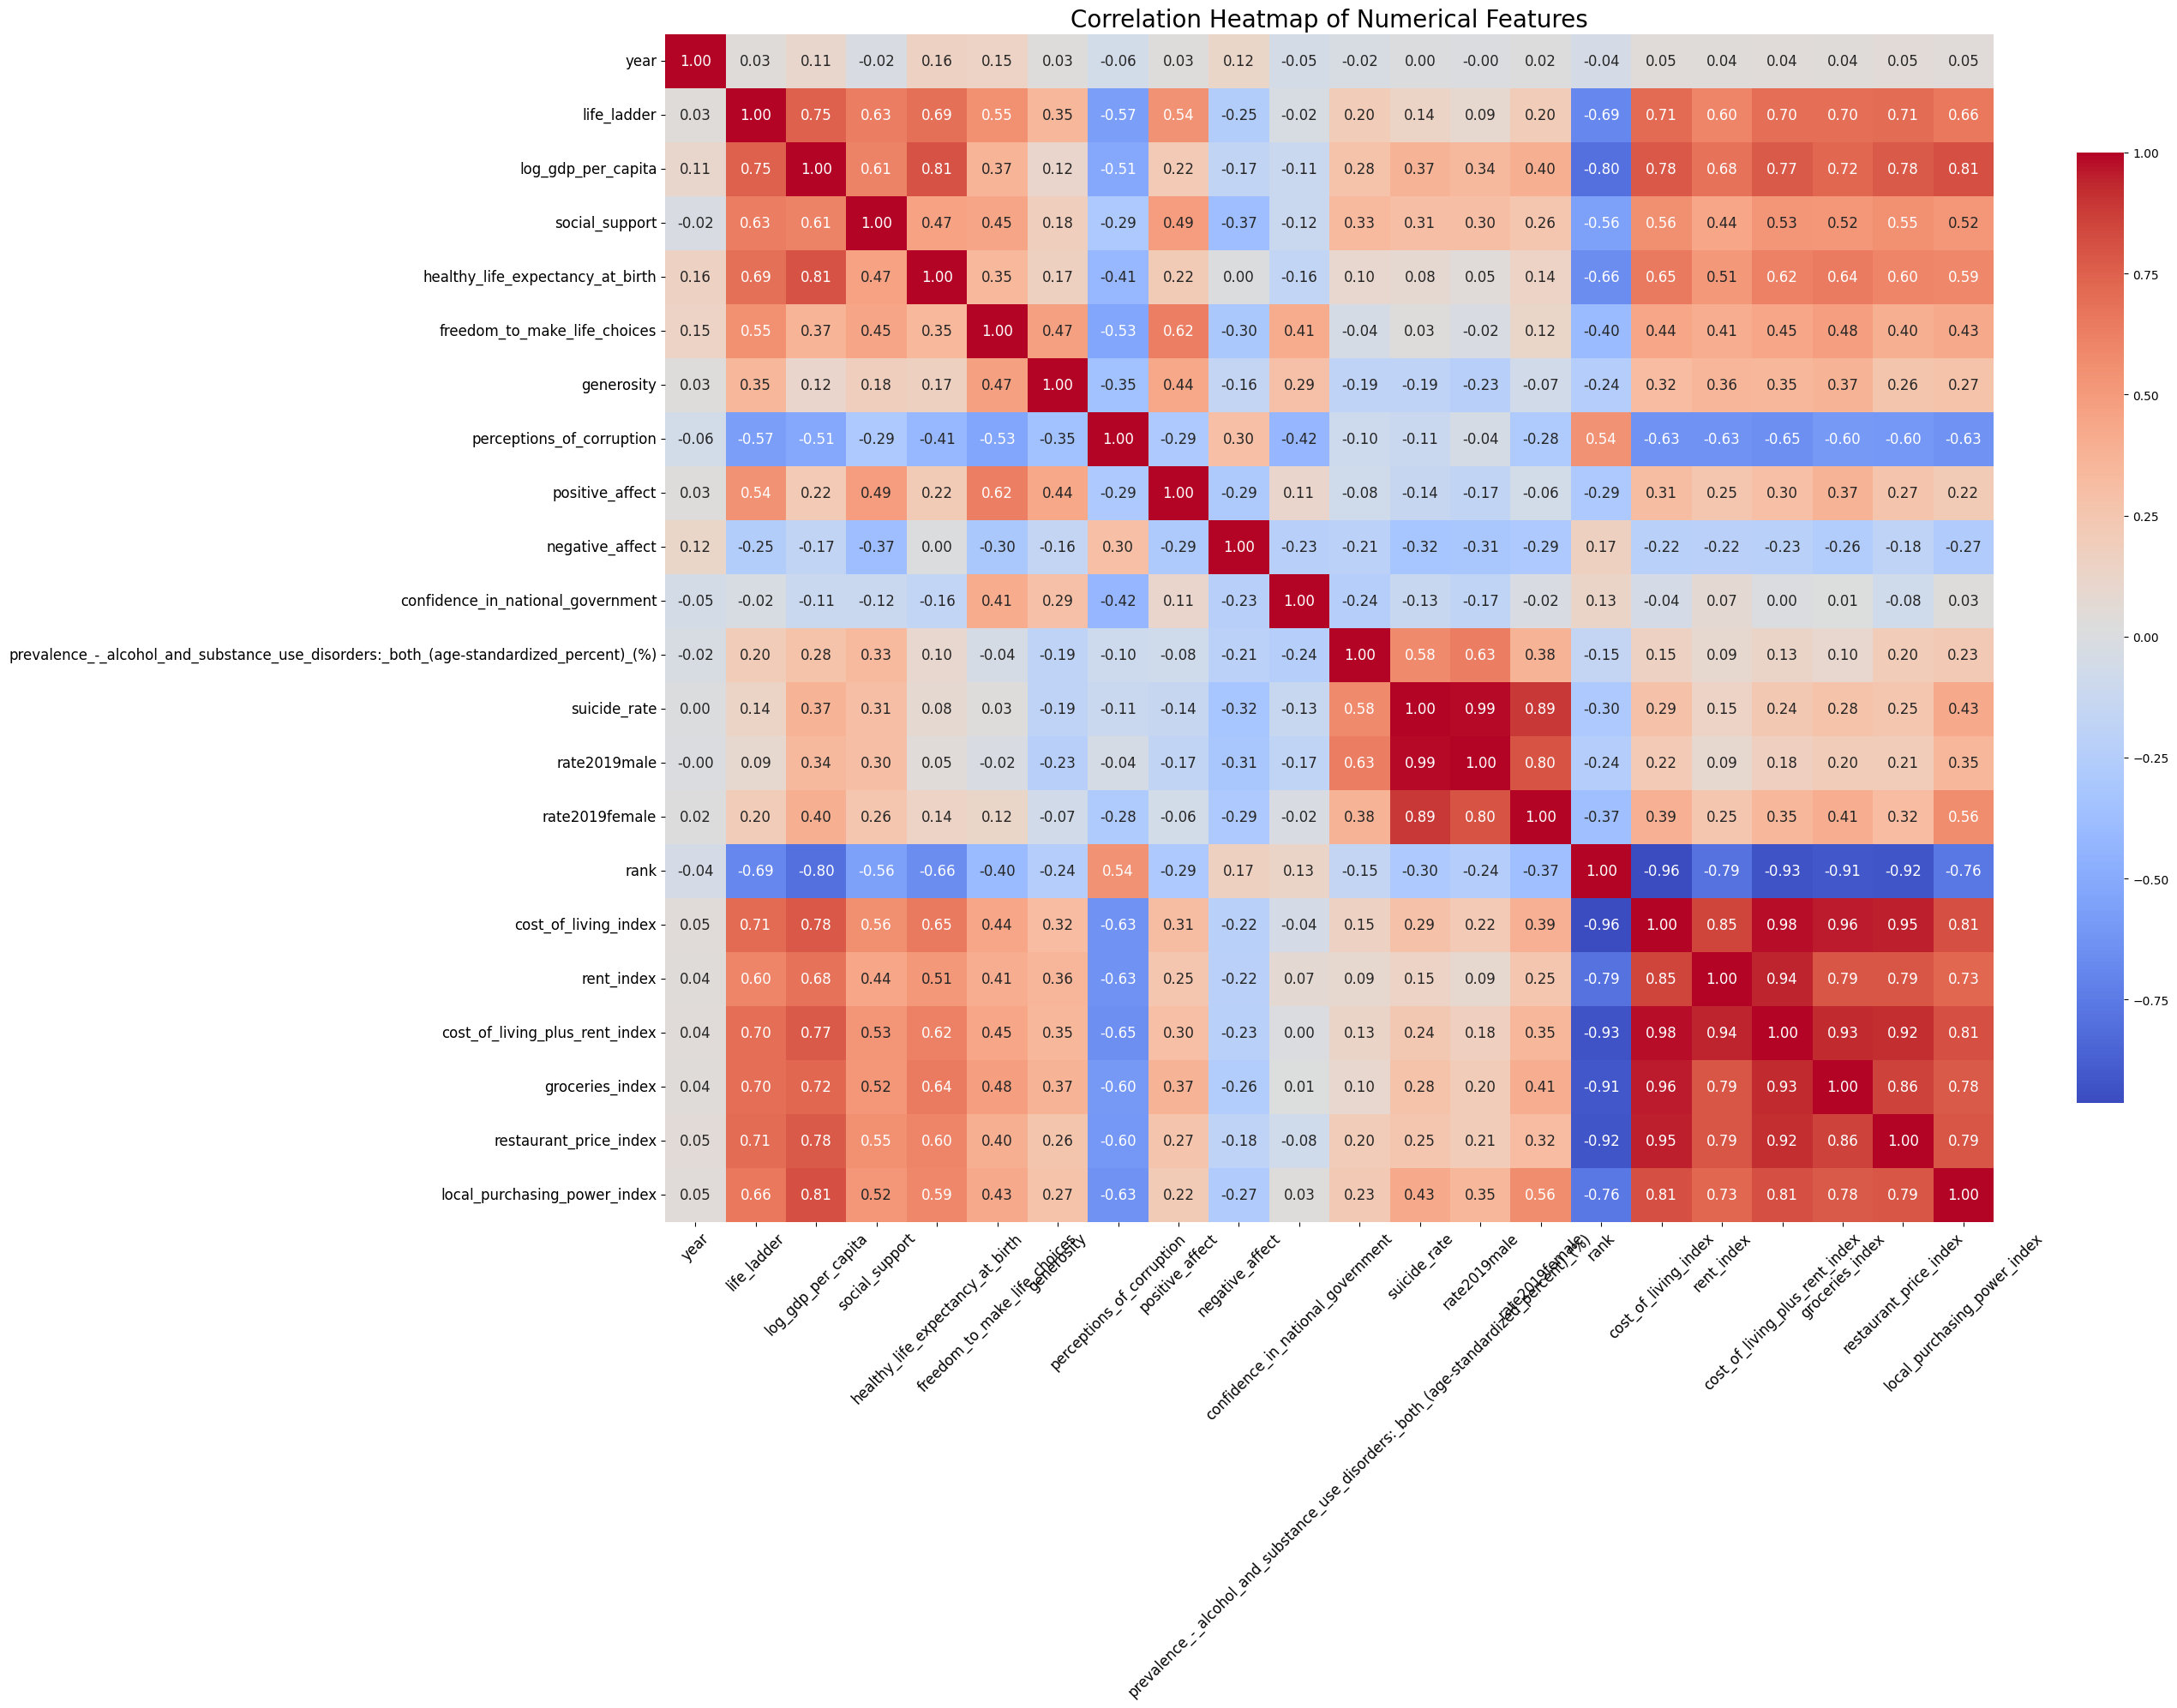

In [ ]:
# Proceed with Advanced Analysis
if not missing_columns:
    # 1. Feature Correlation Analysis
    print("\nPerforming correlation analysis on selected numerical columns.")

    # Select numeric columns and drop missing values
    numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()
    analysis_df = merged_df[numeric_columns].dropna()

    if not analysis_df.empty:
        # Compute the correlation matrix
        correlation_matrix = analysis_df.corr()
        print("\nCorrelation Matrix:")
        print(correlation_matrix)

        # Plot the heatmap with enhanced visibility
        plt.figure(figsize=(25, 18))  # Increase the figure size for better readability
        sns.heatmap(
            correlation_matrix,
            annot=True,  # Enable annotations for correlation coefficients
            cmap='coolwarm',  # Set the color map
            fmt=".2f",  # Format annotations to 2 decimal places
            annot_kws={"size": 12},  # Set annotation font size
            cbar_kws={"shrink": 0.8},  # Adjust the color bar size
            xticklabels=correlation_matrix.columns,  # Customize x-axis labels
            yticklabels=correlation_matrix.columns  # Customize y-axis labels
        )
        plt.title('Correlation Heatmap of Numerical Features', fontsize=20)  # Title font size
        plt.xticks(fontsize=12, rotation=45)  # X-axis labels: Adjust size and rotate
        plt.yticks(fontsize=12)  # Y-axis labels: Adjust size
        plt.show()
    else:
        print("Not enough data for correlation analysis after dropping missing values.")


Regression Model Performance:
R-squared: 0.7539734122683763
Mean Squared Error: 0.321668725559671


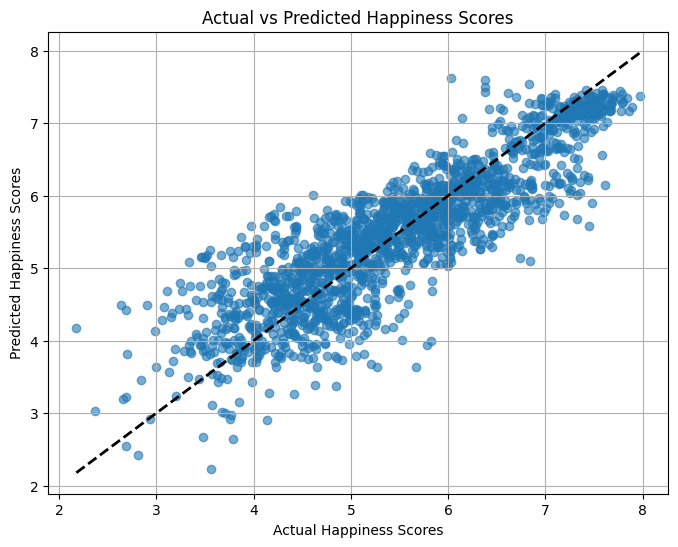

In [ ]:
# 2. Predictive Modeling: Predicting Happiness Score using Multiple Regression
regression_columns = [
    'life_ladder',
    'log_gdp_per_capita',
    'social_support',
    'healthy_life_expectancy_at_birth',
    'freedom_to_make_life_choices',
    'generosity',
    'perceptions_of_corruption'
]

# Check for missing regression columns
missing_regression_columns = [col for col in regression_columns if col not in merged_df.columns]

if not missing_regression_columns:
    # Prepare the data for regression
    model_df = merged_df[regression_columns].dropna()  # Remove rows with missing values
    X = model_df.drop('life_ladder', axis=1)  # Features
    y = model_df['life_ladder']  # Target variable

    # Create and fit the regression model
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)

    # Evaluate the model
    r2 = r2_score(y, y_pred)  # R-squared metric
    mse = mean_squared_error(y, y_pred)  # Mean Squared Error

    # Print the performance metrics
    print(f"\nRegression Model Performance:")
    print(f"R-squared: {r2}")
    print(f"Mean Squared Error: {mse}")

    # Visualize actual vs predicted happiness scores
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.6)
    plt.xlabel('Actual Happiness Scores')
    plt.ylabel('Predicted Happiness Scores')
    plt.title('Actual vs Predicted Happiness Scores')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Reference line
    plt.grid(True)
    plt.show()
else:
    # Handle missing columns
    print(f"Cannot perform regression analysis. Missing columns: {missing_regression_columns}")

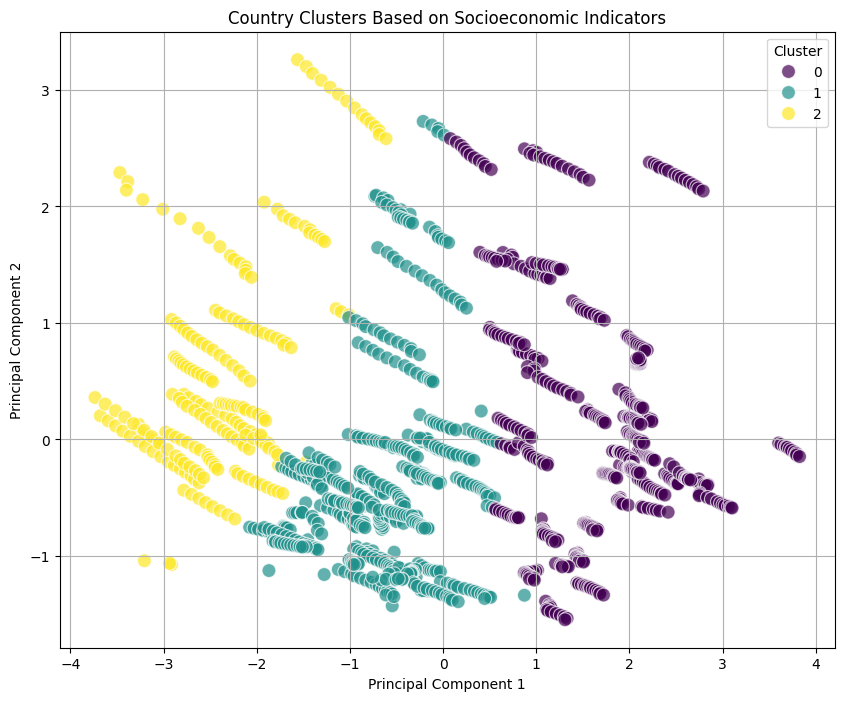

In [ ]:
    # 3. Clustering Countries Based on Socioeconomic Indicators
    clustering_columns = [
        'log_gdp_per_capita',
        'healthy_life_expectancy_at_birth',
        'suicide_rate',
        'cost_of_living_index'
    ]

    # Identify any missing columns required for clustering
    missing_clustering_columns = [col for col in clustering_columns if col not in merged_df.columns]

    if not missing_clustering_columns:
        # Select relevant columns and drop rows with missing values
        clustering_df = merged_df[['country_name'] + clustering_columns].dropna()

        # Set 'country_name' as the index for better readability in plots
        clustering_df.set_index('country_name', inplace=True)

        # Feature Scaling: Standardize the features to have mean=0 and variance=1
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(clustering_df)

        # Clustering: Apply K-Means clustering algorithm
        kmeans = KMeans(n_clusters=3, random_state=42)
        clustering_df['Cluster'] = kmeans.fit_predict(scaled_features)

        # Dimensionality Reduction: Reduce to 2 principal components for visualization
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(scaled_features)
        clustering_df['PC1'] = principal_components[:, 0]
        clustering_df['PC2'] = principal_components[:, 1]

        # Visualization: Scatter plot of the clusters based on principal components
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=clustering_df,
            x='PC1',
            y='PC2',
            hue='Cluster',
            palette='viridis',
            s=100,
            alpha=0.7
        )
        plt.title('Country Clusters Based on Socioeconomic Indicators')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title='Cluster')
        plt.grid(True)
        plt.show()
    else:
        print(f"Cannot perform clustering analysis. Missing columns: {missing_clustering_columns}")


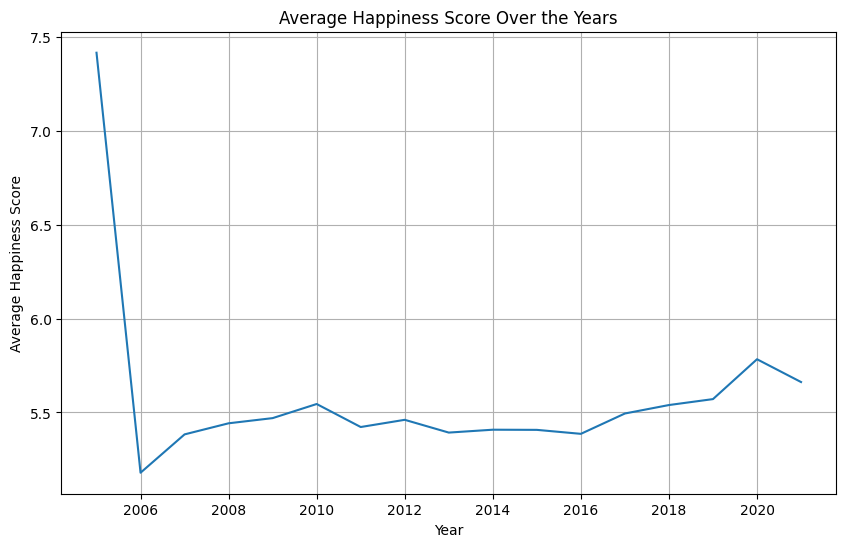

In [ ]:
# Import the logging module
import logging

# Configure logging settings
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# 4. Time Series Analysis of Happiness Scores Over the Years
if 'year' in merged_df.columns and 'life_ladder' in merged_df.columns:
    logging.info("Performing time series analysis.")

    # Select and clean data for time series analysis
    time_series_df = merged_df[['year', 'life_ladder']].dropna()

    # Group by year and calculate the mean of 'life_ladder'
    time_series_df = time_series_df.groupby('year').mean().reset_index()

    # Plot the time series data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=time_series_df, x='year', y='life_ladder')
    plt.title('Average Happiness Score Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Happiness Score')
    plt.grid(True)
    plt.show()
else:
    print("Cannot perform time series analysis. Required columns 'year' and 'life_ladder' not found.")

In [ ]:
# Re-importing necessary libraries and reloading the dataset after the environment reset
import pandas as pd

# Path to the uploaded dataset
new_dataset_path = '/content/final_merged_data.csv'

# Load the dataset into a DataFrame
final_merged_data = pd.read_csv(new_dataset_path)

# Display information about the new dataset to identify relevant columns for merging
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747 entries, 0 to 1746
Data columns (total 24 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   country_name                                                                           1747 non-null   object 
 1   year                                                                                   1747 non-null   int64  
 2   life_ladder                                                                            1747 non-null   float64
 3   log_gdp_per_capita                                                                     1747 non-null   float64
 4   social_support                                                                         1747 non-null   float64
 5   healthy_life_expectancy_at_birth                                            